# Question - Median value of owner-occupied homes in $1000s

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# EDA

In [4]:
# Import the data to session storage
df = pd.read_csv('boston_housing.csv')
df.head()

,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


In [5]:
# Correlation
df.corr()['MEDV'].sort_values(ascending=False)

,MEDV
MEDV,1.000000
RM,0.695360
ZN,0.360445
DIS,0.249929
CHAS,0.175260
Unnamed: 0,-0.226604
AGE,-0.376955
RAD,-0.381626
CRIM,-0.388305
NOX,-0.427321


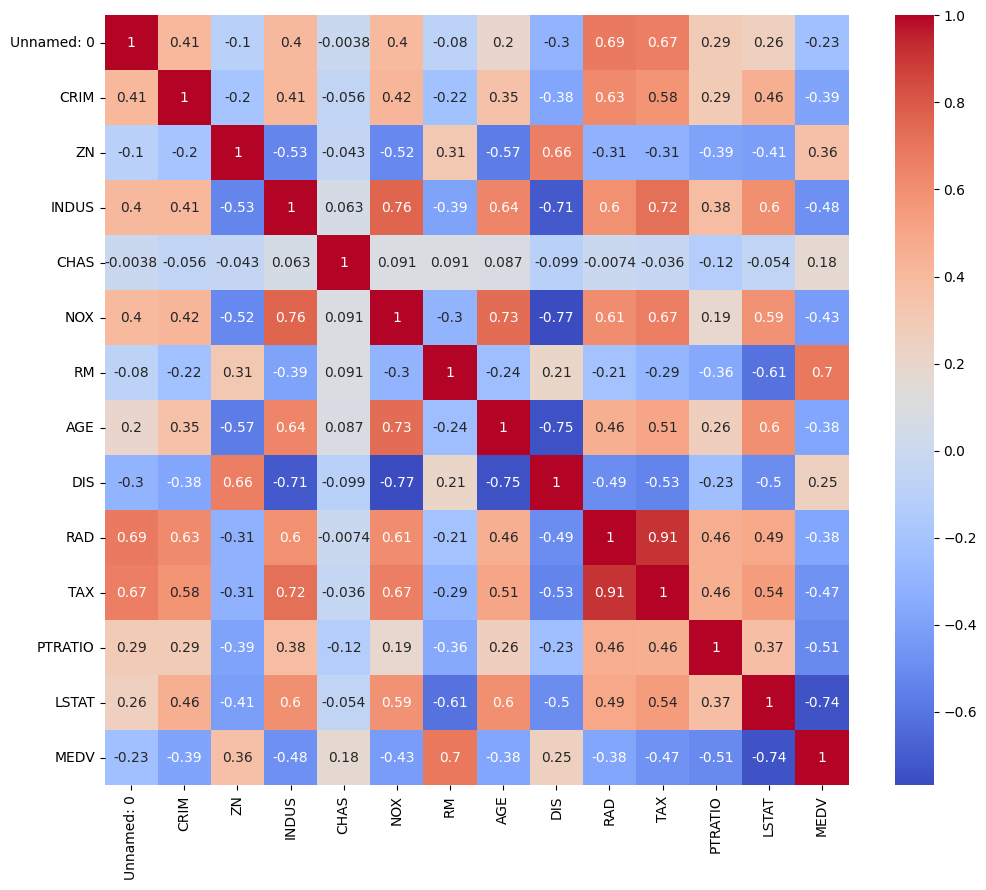

In [6]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [7]:
correlation_with_medv = df.corr()['MEDV']

# Finding columns with absolute correlation less than 0.3
columns_to_drop = correlation_with_medv[abs(correlation_with_medv) < 0.3].index.tolist()

# Dropping these columns
dropped_df = df.drop(columns=columns_to_drop)
print(columns_to_drop, " were dropped due to low correlation with MEDV")
dropped_df.shape

['Unnamed: 0', 'CHAS', 'DIS']  were dropped due to low correlation with MEDV


(506, 11)

In [8]:
def plot_corr(column):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=column, y='MEDV', data=df)
    plt.xlabel(column)
    plt.ylabel('Median Home Value (MEDV)')
    plt.title(f'Correlation between {column} and Median Home Value')
    plt.show()

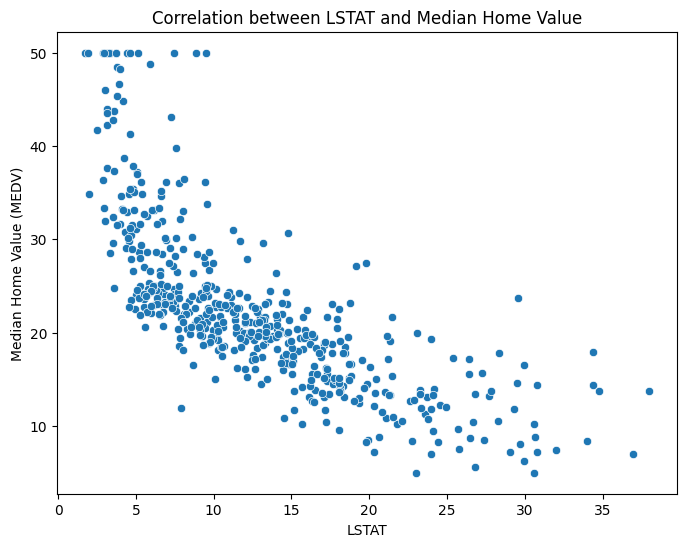

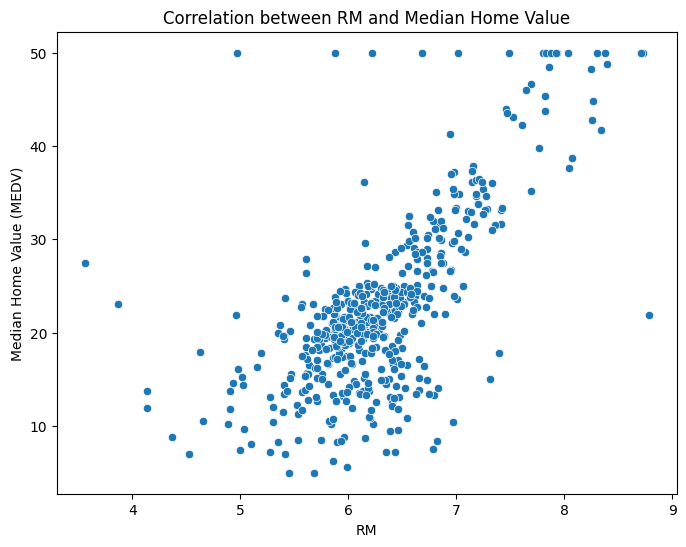

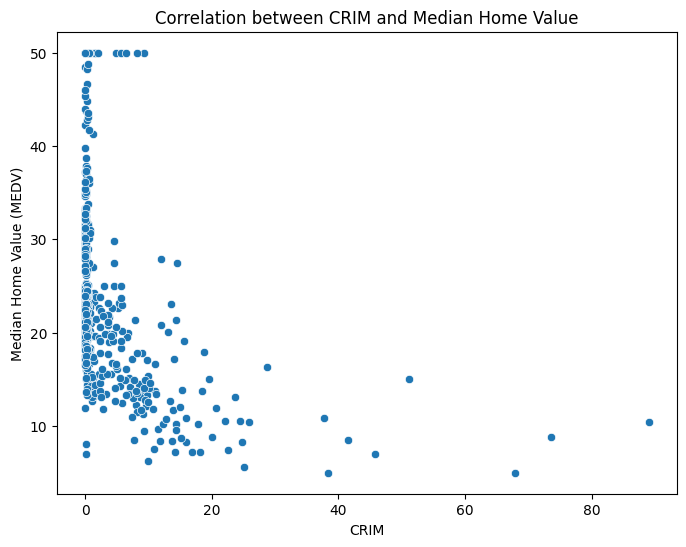

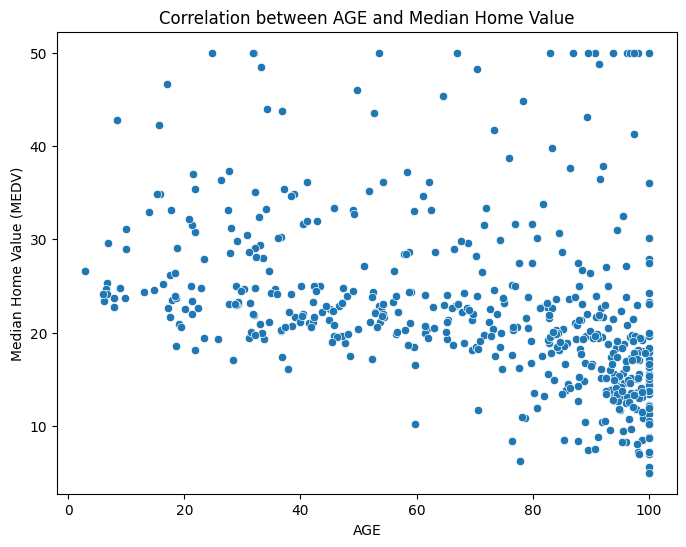

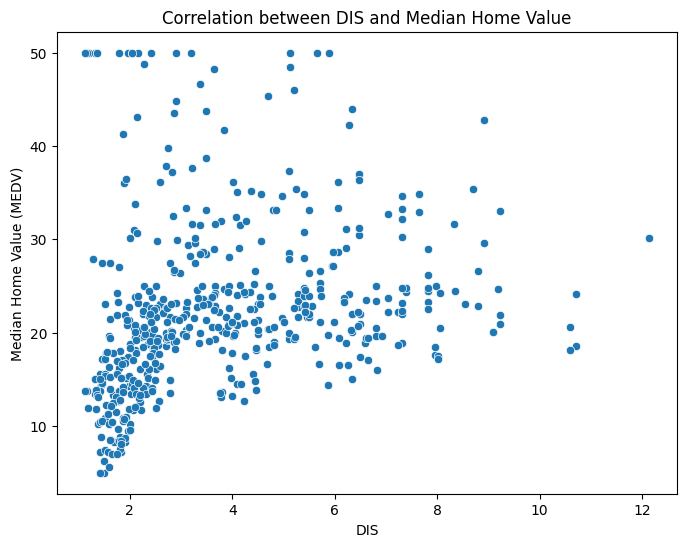

In [9]:
# Visualizing the relationship between MEDV and some correlated columns in a scatter plot
for column in ["LSTAT","RM","CRIM","AGE","DIS"]:
  plot_corr(column)

In [10]:
dropped_df.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,RAD,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,24.000000,711.000000,22.000000,37.970000,50.000000


In [11]:
# Checking for outliers - Tried it out but weren't happy with the results, thus it is commented
Q1 = dropped_df.quantile(0.25)
Q3 = dropped_df.quantile(0.75)
IQR = Q3 - Q1
outliers = (dropped_df < (Q1 - 1.5 * IQR)) | (dropped_df > (Q3 + 1.5 * IQR))
print(outliers)

new_df = dropped_df#[~outliers.any(axis=1)]
new_df.shape

      CRIM     ZN  INDUS    NOX     RM    AGE    RAD    TAX  PTRATIO  LSTAT  \
0    False  False  False  False  False  False  False  False    False  False   
1    False  False  False  False  False  False  False  False    False  False   
2    False  False  False  False  False  False  False  False    False  False   
3    False  False  False  False  False  False  False  False    False  False   
4    False  False  False  False  False  False  False  False    False  False   
..     ...    ...    ...    ...    ...    ...    ...    ...      ...    ...   
501  False  False  False  False  False  False  False  False    False  False   
502  False  False  False  False  False  False  False  False    False  False   
503  False  False  False  False  False  False  False  False    False  False   
504  False  False  False  False  False  False  False  False    False  False   
505  False  False  False  False  False  False  False  False    False  False   

      MEDV  
0    False  
1    False  
2    False  

(506, 11)

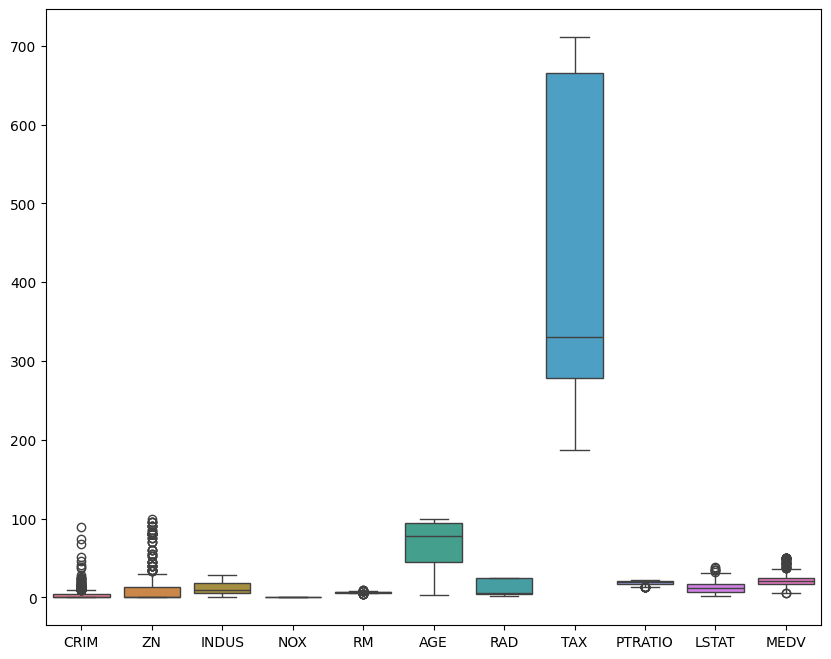

In [12]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=new_df)
plt.show()

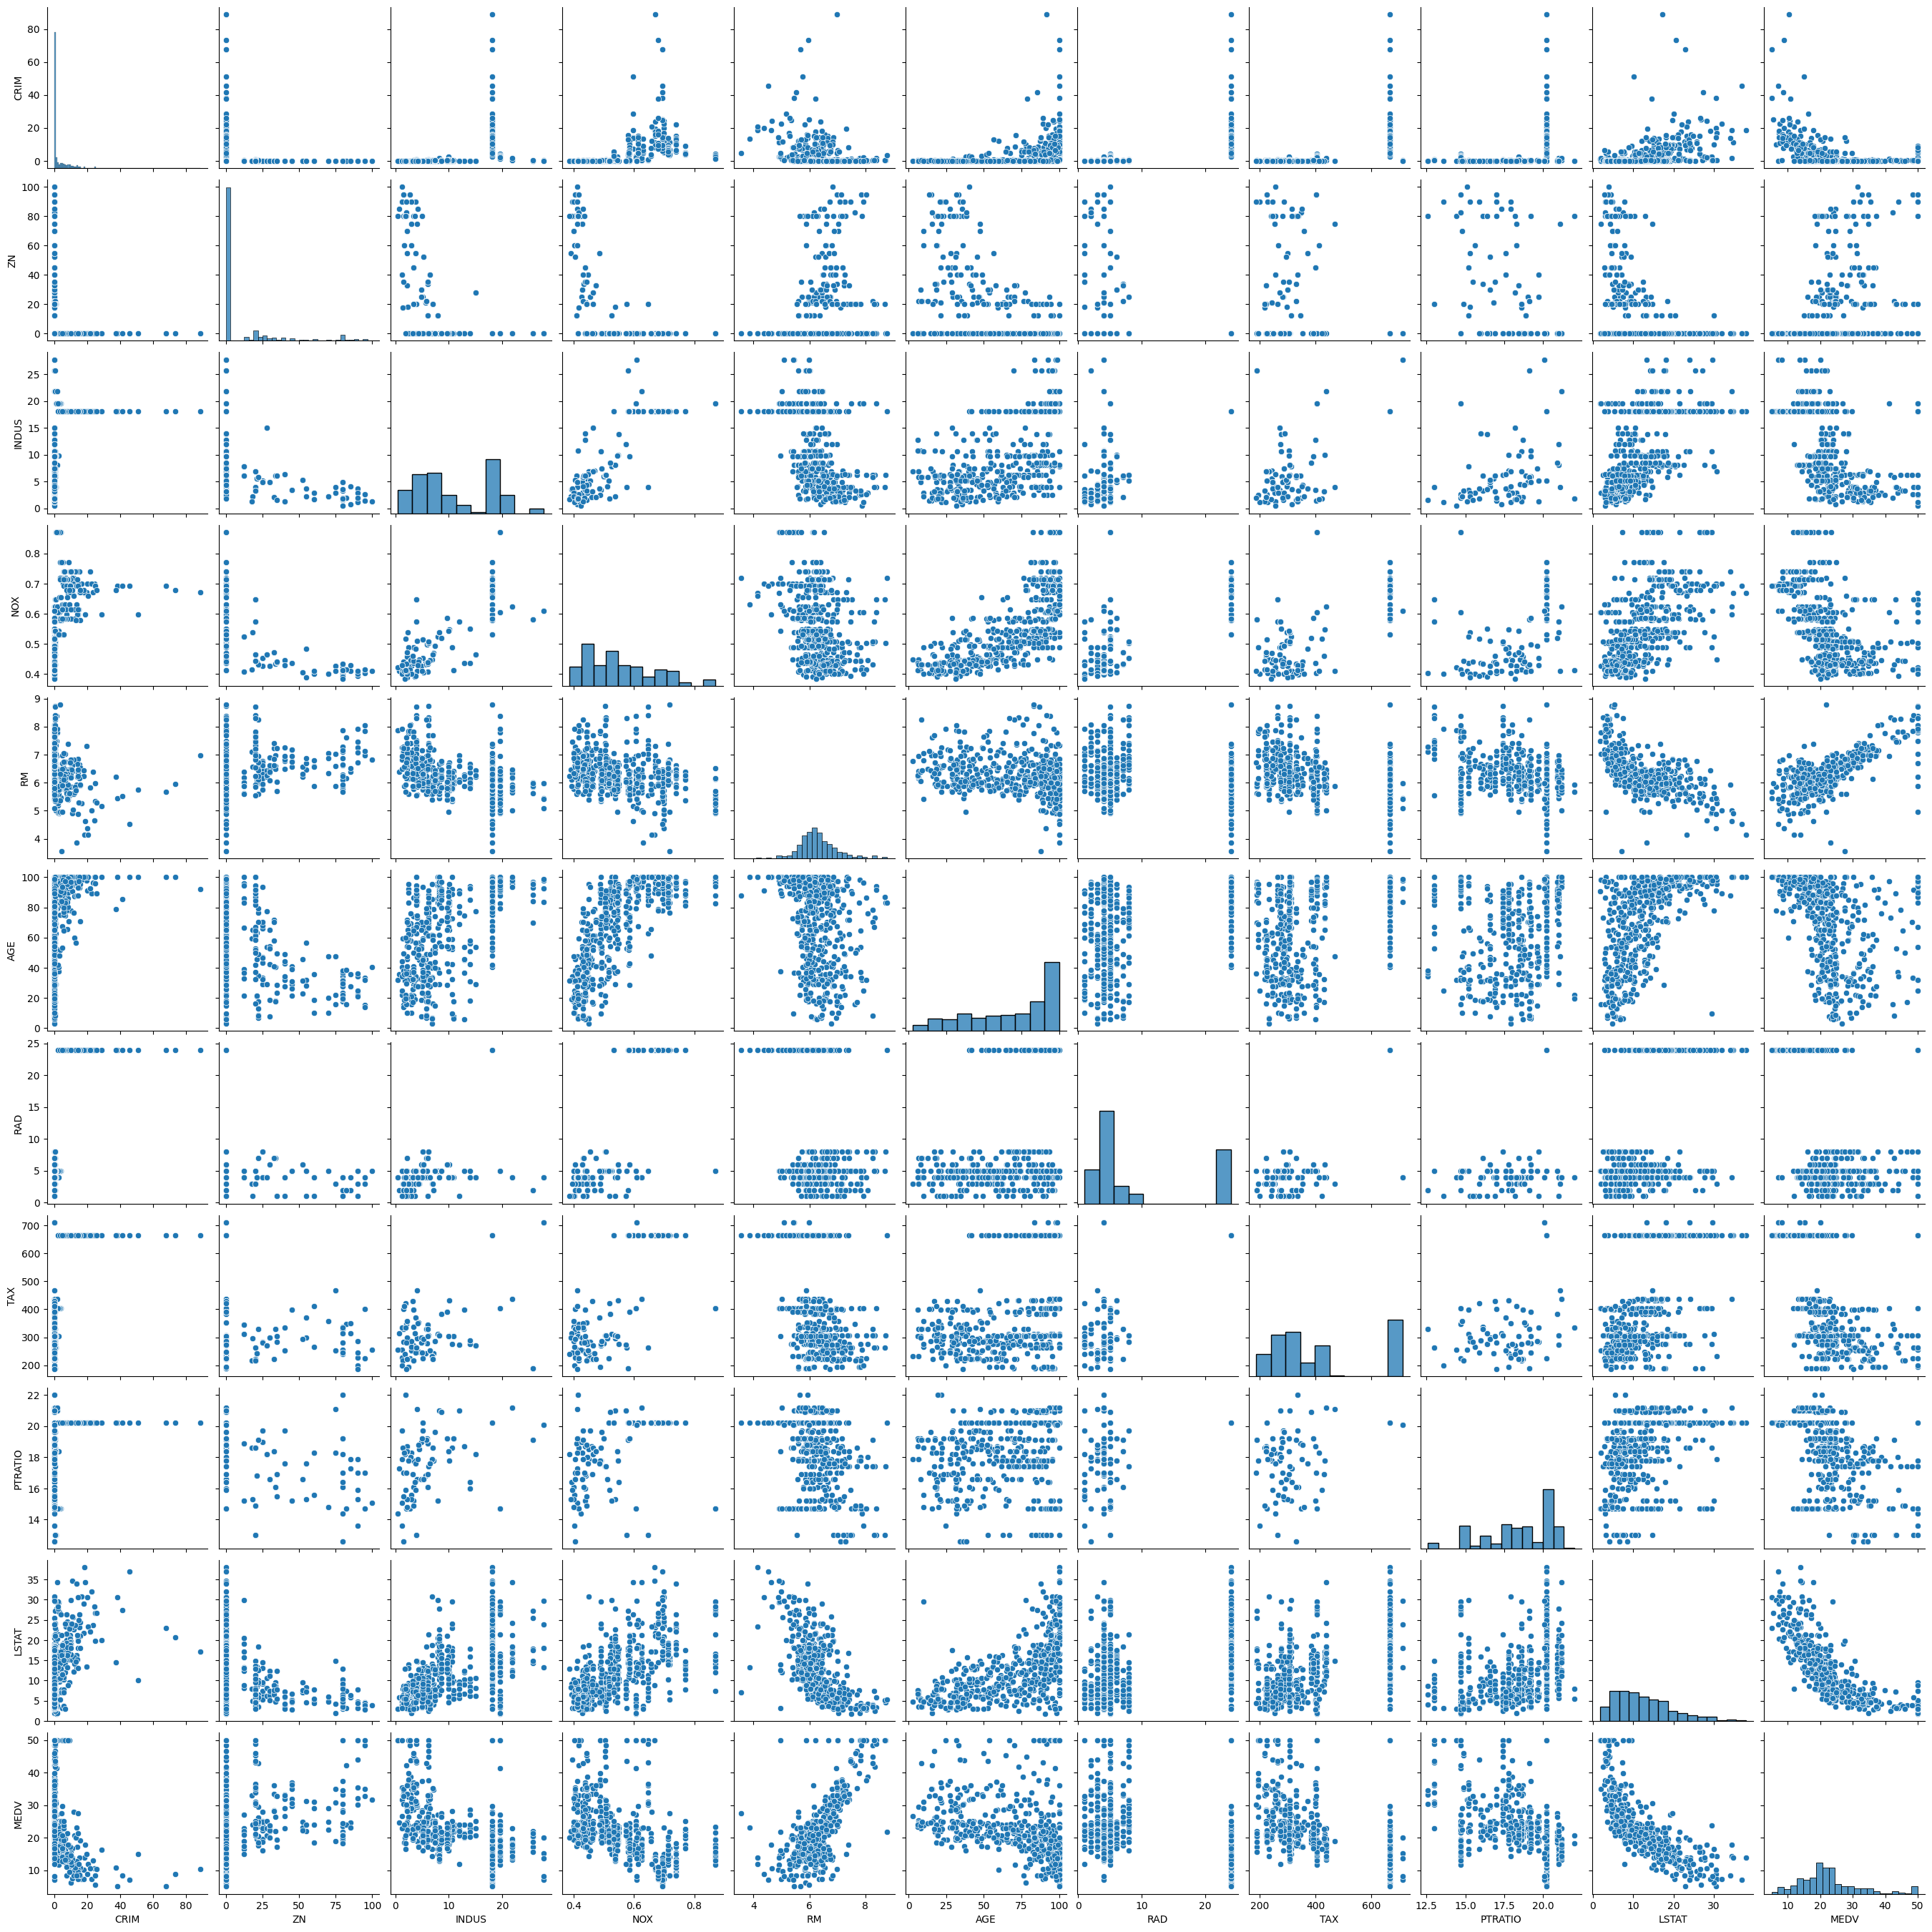

In [13]:
# Visualizing the data
sns.pairplot(new_df)

<Axes: title={'center': 'Distribution of Median Value'}, ylabel='Frequency'>

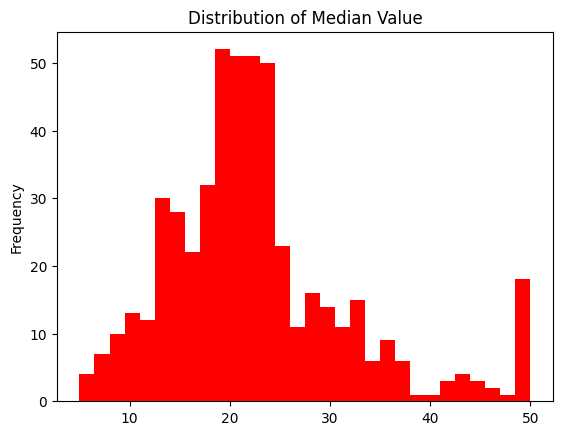

In [14]:
new_df["MEDV"].plot(kind="hist", bins=30, title="Distribution of Median Value", color='red')

# Data Processing

In [15]:
# Converting every column to numeric
for col in new_df.columns:
    new_df.loc[:, col] = pd.to_numeric(new_df[col], errors='coerce')

In [16]:
# Features and target
X = new_df.drop('MEDV', axis=1)
y = new_df['MEDV']
X.shape, y.shape

((506, 10), (506,))

# Training, Testing and Evaluating

In [17]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

In [18]:
def cross_validation(X, y, model, scaler=None, k=5):
  size = X.shape[0]
  fold_size = size // k
  indices = np.arange(size)
  np.random.shuffle(indices)
  X = X.iloc[indices]
  y = y.iloc[indices]

  mse_scores = []
  r2_scores = []

  for i in range(k):
      start = i * fold_size
      end = start + fold_size
      X_test = X.iloc[start:end]
      y_test = y.iloc[start:end]

      X_train = pd.concat([X.iloc[:start], X.iloc[end:]])
      y_train = pd.concat([y.iloc[:start], y.iloc[end:]])

      # y_train.plot(kind="hist", title=f"Round {i}", bins=30, color='red')
      # plt.show()

      X_train_scaled = X_train
      X_test_scaled = X_test

      if scaler is not None:
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

      model.fit(X_train_scaled, y_train)

      y_pred = model.predict(X_test_scaled)
      mse = mean_squared_error(y_test, y_pred)
      r2 = r2_score(y_test, y_pred)

      mse_scores.append(mse)
      r2_scores.append(r2)

  return mse_scores, r2_scores

def train_test_split_model(X, y, model, scaler=None, test_size=0.2, random_state=42):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  X_train_scaled = X_train
  X_test_scaled = X_test

  if scaler is not None:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

  model.fit(X_train_scaled, y_train)
  y_pred = model.predict(X_test_scaled)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  return mse, r2

def print_scores(scores_cross_validation, scores_train_test_split):
  print("Cross-validation")
  print("MSE:", np.mean(scores_cross_validation[0]))
  print("R² score:", np.mean(scores_cross_validation[1]))

  print("Train-test split")
  print("MSE:", scores_train_test_split[0])
  print("R² score:", scores_train_test_split[1])

In [19]:
results_df = pd.DataFrame(columns=['Model', 'Scaler', 'Method', 'MSE', 'R2'])

## Linear model

In [20]:
linear_model = LinearRegression()
scores1 = cross_validation(X, y, linear_model, standard_scaler)
scores2 = train_test_split_model(X, y, linear_model, standard_scaler)

print_scores(scores1, scores2)

results_df.loc[len(results_df)] = ['Linear', 'Standard', 'Cross-validation', np.mean(scores1[0]), np.mean(scores1[1])]
results_df.loc[len(results_df)] = ['Linear', 'Standard', 'Train-test split', scores2[0], scores2[1]]

Cross-validation
MSE: 28.959424549833624
R² score: 0.6500303263397831
Train-test split
MSE: 26.12867107545151
R² score: 0.6437021254129385


In [21]:
coefficients = pd.DataFrame(linear_model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

         Coefficient
CRIM       -0.986263
ZN         -0.278747
INDUS       0.851492
NOX        -1.131697
RM          3.309842
AGE         0.798769
RAD         2.166272
TAX        -1.927410
PTRATIO    -2.288389
LSTAT      -4.030031


## Random forest

In [22]:
random_forest_model = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=random_forest_model,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

best_random_forest_model = random_search.best_estimator_
y_pred = best_random_forest_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R² score:", r2)

results_df.loc[len(results_df)] = ['Random forest', 'None', 'Train-test split', mse, r2]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Best score: 0.8382908686364839
MSE: 9.597956134803919
R² score: 0.8691195828010021


## Support Vector Regressor

In [23]:
support_regressor = SVR()

scores1 = cross_validation(X, y, support_regressor, standard_scaler)
scores2 = train_test_split_model(X, y, support_regressor, standard_scaler)

print("Standard scaler")
print_scores(scores1, scores2)
results_df.loc[len(results_df)] = ['Support vector regressor', 'Standard', 'Cross-validation', np.mean(scores1[0]), np.mean(scores1[1])]
results_df.loc[len(results_df)] = ['Support vector regressor', 'Standard', 'Train-test split', scores2[0], scores2[1]]

scores1 = cross_validation(X, y, support_regressor, min_max_scaler)
scores2 = train_test_split_model(X, y, support_regressor, min_max_scaler)

print("\nMin-max scaler")
print_scores(scores1, scores2)
results_df.loc[len(results_df)] = ['Support vector regressor', 'Min-max', 'Cross-validation', np.mean(scores1[0]), np.mean(scores1[1])]
results_df.loc[len(results_df)] = ['Support vector regressor', 'Min-max', 'Train-test split', scores2[0], scores2[1]]

Standard scaler
Cross-validation
MSE: 27.74929188791225
R² score: 0.671510821008475
Train-test split
MSE: 25.947088361352403
R² score: 0.6461782381439853

Min-max scaler
Cross-validation
MSE: 31.89543994896555
R² score: 0.6283913360331488
Train-test split
MSE: 28.435114158388963
R² score: 0.612250821749863


## XGBoost Regressor

In [24]:
xgboost_model = XGBRegressor()

scores1 = cross_validation(X, y, xgboost_model, standard_scaler)
scores2 = train_test_split_model(X, y, xgboost_model, standard_scaler)

print("Standard scaler")
print_scores(scores1, scores2)
results_df.loc[len(results_df)] = ['XGBoost', 'Standard', 'Cross-validation', np.mean(scores1[0]), np.mean(scores1[1])]
results_df.loc[len(results_df)] = ['XGBoost', 'Standard', 'Train-test split', scores2[0], scores2[1]]

# No scaling
scores1 = cross_validation(X, y, xgboost_model)
scores2 = train_test_split_model(X, y, xgboost_model)

print("\nNo scaling")
print_scores(scores1, scores2)
results_df.loc[len(results_df)] = ['XGBoost', 'None', 'Cross-validation', np.mean(scores1[0]), np.mean(scores1[1])]
results_df.loc[len(results_df)] = ['XGBoost', 'None', 'Train-test split', scores2[0], scores2[1]]

coefficients = pd.DataFrame(xgboost_model.feature_importances_, X.columns, columns=['Coefficient'])
print(coefficients)

Standard scaler
Cross-validation
MSE: 11.588083080983768
R² score: 0.857258418105323
Train-test split
MSE: 5.995938962422865
R² score: 0.9182376974972846

No scaling
Cross-validation
MSE: 10.884896503168878
R² score: 0.8710277212245041
Train-test split
MSE: 5.995938962422865
R² score: 0.9182376974972846
         Coefficient
CRIM        0.054056
ZN          0.003711
INDUS       0.011399
NOX         0.058371
RM          0.425888
AGE         0.016378
RAD         0.010729
TAX         0.044611
PTRATIO     0.060158
LSTAT       0.314700


## K-Nearest Neighbors Regressor

In [25]:
knn_model = KNeighborsRegressor()

scores1 = cross_validation(X, y, knn_model, standard_scaler)
scores2 = train_test_split_model(X, y, knn_model, standard_scaler)

print("Standard scaler")
print_scores(scores1, scores2)
results_df.loc[len(results_df)] = ['K-nearest neighbors', 'Standard', 'Cross-validation', np.mean(scores1[0]), np.mean(scores1[1])]
results_df.loc[len(results_df)] = ['K-nearest neighbors', 'Standard', 'Train-test split', scores2[0], scores2[1]]

scores1 = cross_validation(X, y, knn_model, min_max_scaler)
scores2 = train_test_split_model(X, y, knn_model, min_max_scaler)

print("\nMin-max scaler")
print_scores(scores1, scores2)
results_df.loc[len(results_df)] = ['K-nearest neighbors', 'Min-max', 'Cross-validation', np.mean(scores1[0]), np.mean(scores1[1])]
results_df.loc[len(results_df)] = ['K-nearest neighbors', 'Min-max', 'Train-test split', scores2[0], scores2[1]]

Standard scaler
Cross-validation
MSE: 15.196460198019803
R² score: 0.8150455904588135
Train-test split
MSE: 14.399564705882353
R² score: 0.8036435039168524

Min-max scaler
Cross-validation
MSE: 16.694985346534654
R² score: 0.8034778914392253
Train-test split
MSE: 12.431062745098039
R² score: 0.8304865478176526


## AdaBoost Regressor

In [26]:
adaboost_model = AdaBoostRegressor()

scores1 = cross_validation(X, y, adaboost_model)
scores2 = train_test_split_model(X, y, adaboost_model)

print_scores(scores1, scores2)
results_df.loc[len(results_df)] = ['AdaBoost', 'None', 'Cross-validation', np.mean(scores1[0]), np.mean(scores1[1])]
results_df.loc[len(results_df)] = ['AdaBoost', 'None', 'Train-test split', scores2[0], scores2[1]]

Cross-validation
MSE: 14.852368429657833
R² score: 0.8206658349465087
Train-test split
MSE: 10.898166506950687
R² score: 0.8513895501187356


# Analysis

In [27]:
results_df

,Model,Scaler,Method,MSE,R2
0,Linear,Standard,Cross-validation,28.959425,0.650030
1,Linear,Standard,Train-test split,26.128671,0.643702
2,Random forest,None,Train-test split,9.597956,0.869120
3,Support vector regressor,Standard,Cross-validation,27.749292,0.671511
4,Support vector regressor,Standard,Train-test split,25.947088,0.646178
5,Support vector regressor,Min-max,Cross-validation,31.895440,0.628391
6,Support vector regressor,Min-max,Train-test split,28.435114,0.612251
7,XGBoost,Standard,Cross-validation,11.588083,0.857258
8,XGBoost,Standard,Train-test split,5.995939,0.918238
9,XGBoost,None,Cross-validation,10.884897,0.871028


In [28]:
results_df.sort_values(by=['R2'], ascending=False)

,Model,Scaler,Method,MSE,R2
8,XGBoost,Standard,Train-test split,5.995939,0.918238
10,XGBoost,None,Train-test split,5.995939,0.918238
9,XGBoost,None,Cross-validation,10.884897,0.871028
2,Random forest,None,Train-test split,9.597956,0.869120
7,XGBoost,Standard,Cross-validation,11.588083,0.857258
16,AdaBoost,None,Train-test split,10.898167,0.851390
14,K-nearest neighbors,Min-max,Train-test split,12.431063,0.830487
15,AdaBoost,None,Cross-validation,14.852368,0.820666
11,K-nearest neighbors,Standard,Cross-validation,15.196460,0.815046
12,K-nearest neighbors,Standard,Train-test split,14.399565,0.803644


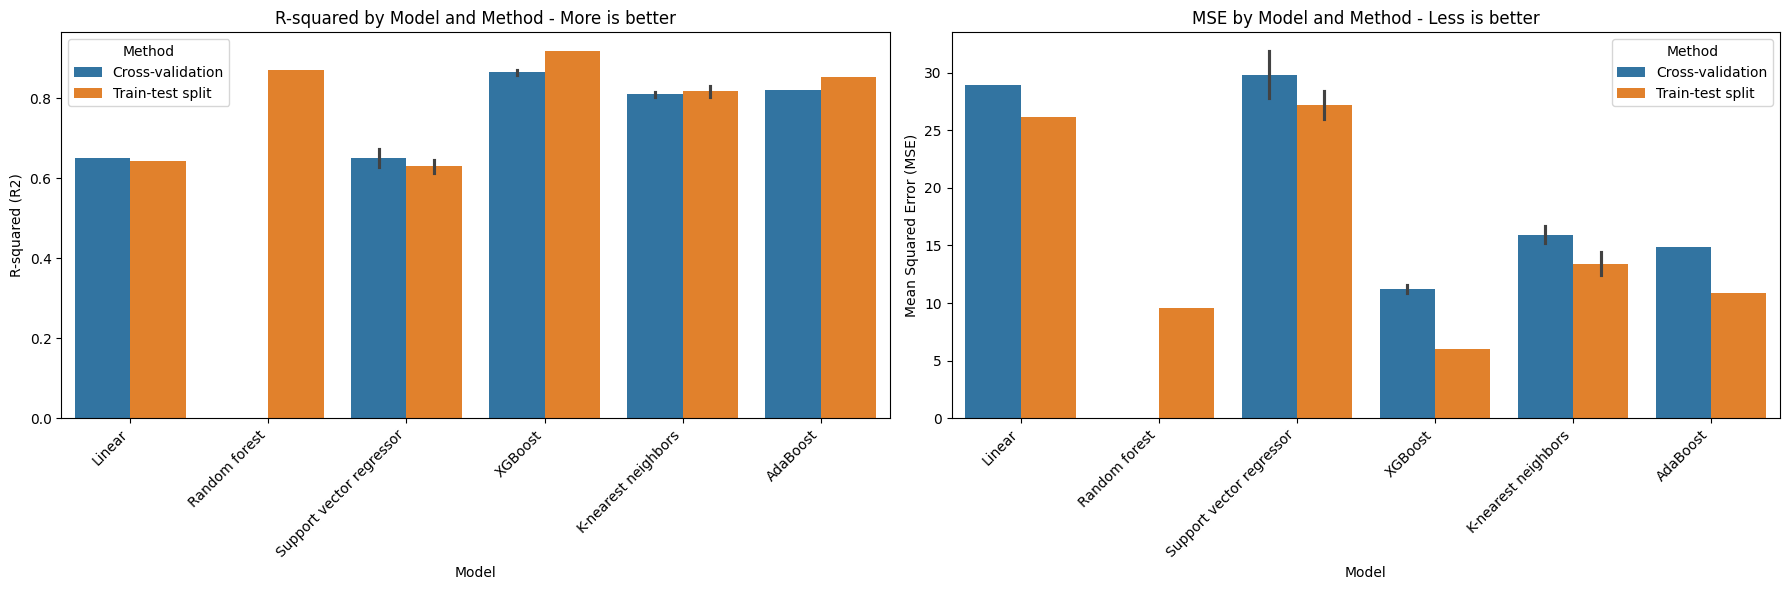

In [29]:
# R-squared by model and method
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='R2', hue='Method', data=results_df)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('R-squared (R2)')
_ = plt.title('R-squared by Model and Method - More is better')

# MSE by model and method
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='MSE', hue='Method', data=results_df)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
_ = plt.title('MSE by Model and Method - Less is better')

plt.tight_layout()
plt.show()

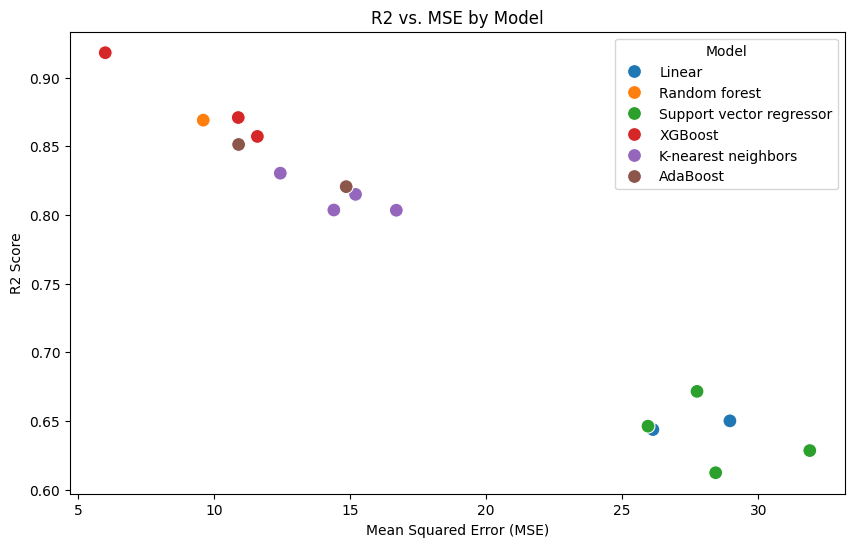

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MSE', y='R2', hue='Model', data=results_df, s=100)
plt.title('R2 vs. MSE by Model')
plt.xlabel('Mean Squared Error (MSE)')
_ = plt.ylabel('R2 Score')